In [1]:
%matplotlib inline

import logging.config
logging.config.fileConfig('../conf/get-kafka-data-logging.conf')
logger = logging.getLogger('mods2')

logger.setLevel(logging.INFO)

import datetime
import joblib
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import seaborn as sns
import sklearn as skl
import tensorflow as tf

from IPython.display import display, HTML

from kafka import KafkaConsumer, KafkaProducer
from kafka.structs import TopicPartition

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from numpy import hstack

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer

# Make the graphs a bit prettier, and bigger
matplotlib.style.use('ggplot')

In [2]:
timestep = pd.Timedelta(minutes=10)

# will be available later:
# topic_in = 'mods-agg-%s' % timestep.isoformat()

topic_in = 'mods-agg-%dm' % timestep.components.minutes
model_dir = os.path.join('..', 'models', 'm2-incr-nostl')

cfg = {
    'timestep': timestep,
    'kafka': {
        'consumer': {
            'topics': [
                topic_in,
                '%s-benign' % topic_in
            ],
            'configs': {
                'client_id': 'mods-stevo-client01',
                'group_id': 'mods-stevo-group01',
                'bootstrap_servers': [
                    '127.0.0.1:9093'
                ],
                'auto_offset_reset': 'earliest',
                'enable_auto_commit': False,
                'value_deserializer': lambda v: json.loads(v.decode('utf-8'))
            }
        }
    },
    'prediction': {
        'model_dir': model_dir,
        'online_model_file': os.path.join(model_dir, 'model-online.h5')
    },
    'training': {
        'benign_threshold': 0.5,
        'update_period': int(pd.Timedelta(days=1) // timestep),
        'update_context_len': int(pd.Timedelta(days=1) // timestep)
    }
}

assert(cfg['training']['update_context_len'] >= cfg['training']['update_period'])

display(cfg)

{'timestep': Timedelta('0 days 00:10:00'),
 'kafka': {'consumer': {'topics': ['mods-agg-10m', 'mods-agg-10m-benign'],
   'configs': {'client_id': 'mods-stevo-client01',
    'group_id': 'mods-stevo-group01',
    'bootstrap_servers': ['127.0.0.1:9093'],
    'auto_offset_reset': 'earliest',
    'enable_auto_commit': False,
    'value_deserializer': <function __main__.<lambda>(v)>}}},
 'prediction': {'model_dir': '../models/m2-incr-nostl',
  'online_model_file': '../models/m2-incr-nostl/model-online.h5'},
 'training': {'benign_threshold': 0.5,
  'update_period': 144,
  'update_context_len': 144}}

In [3]:
def create_consumer(conf):
    logger.debug('creating consumer:\n' + str(conf))
    consumer = None
    consumer = KafkaConsumer(
        **conf['configs']
    )
    logger.debug('subscribing to topics')
    consumer.subscribe(conf['topics'])
    logger.info('consumer created')
    return consumer

def get_model_features(mods2_model):
    features = list(set(mods2_model['cfg']['data']['X'] + mods2_model['cfg']['data']['Y']))
    features.sort()
    return features

def message_to_df(message, features):
    protocol = message.key.decode('ascii')
    df = pd.read_json(message.value, orient='index')
    df.set_index('ts', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    cols = [col for col in df if col in features]
    return df[cols]

def get_model_context_length(mods2_model):
    is_differential = mods2_model['cfg']['differential']
    context_length = mods2_model['cfg']['tsg']['length'] +\
        (mods2_model['cfg']['forecast_steps'] if is_differential else 0)
    return context_length

def load_model(model_dir, online_model_file) -> (Model, Pipeline, Pipeline, dict):
    logger.debug('load_model(model_dir=\'%s\, online_model_file=%s)' % (model_dir, online_model_file))
    # load cfg
    cfg_file = open(os.path.join(model_dir, 'cfg.json'), 'r')
    cfg = json.load(cfg_file)
    cfg_file.close()
    logger.info('model configuration loaded')
    logger.debug(cfg)
    # load transformation pipelines
    transform_pipeline_X = joblib.load(os.path.join(model_dir, 'sklearn_pipeline_X.pkl'))
    transform_pipeline_Y = joblib.load(os.path.join(model_dir, 'sklearn_pipeline_Y.pkl'))
    # load model
    model_file = None
    if os.path.isfile(online_model_file):
        model_file = online_model_file
    else:
        model_file = os.path.join(model_dir, 'model.h5')
    logger.info('loading model: %s' % model_file)
    model = tf.keras.models.load_model(model_file)
    logger.info('model loaded')
    mods2_model = {
        'model': model,
        'transform_pipeline_X': transform_pipeline_X,
        'transform_pipeline_Y': transform_pipeline_Y,
        'cfg': cfg
    }
    return mods2_model


# returns: true if the buffer has at least required_length rows and
#                  there are no null values in the first and the last row
def buffer_ready(buffer, required_length):
    return buffer.shape[0] >= required_length\
            and (not buffer[-required_length:1].isnull().values.any())\
            and (not buffer[-1:].isnull().values.any())

def buffer_trim_null(buffer):
    while buffer[:1].isnull().values.any():
        buffer = buffer[1:]
    while buffer[-1:].isnull().values.any():
        buffer = buffer[:-1]
    return buffer

def differentiate(df:pd.DataFrame, k) -> pd.DataFrame:
    return df[k:]-df[:-k].values


def inverse_differentiate(df:pd.DataFrame, seen:pd.DataFrame, k) -> pd.DataFrame:
    return seen.values+df


def transform(mods2_model:dict, df:pd.DataFrame) -> pd.DataFrame:
    isdiff = mods2_model['cfg']['differential']
    if isdiff:
        forecast_steps = mods2_model['cfg']['forecast_steps']
        return differentiate(df, forecast_steps)
    else:
        return df

    
def inverse_transform(mods2_model:dict, df:pd.DataFrame, df_orig:pd.DataFrame) -> pd.DataFrame:
    isdiff = mods2_model['cfg']['differential']
    if isdiff:
        sequence_length = mods2_model['cfg']['tsg']['length']
        forecast_steps = mods2_model['cfg']['forecast_steps']
        prev = df_orig[-1:].values
        return df + prev
    else:
        return df


def predict(mods2_model, df, timestep=cfg['timestep'], verbose=0):
    model = mods2_model['model']
    forecast_steps = mods2_model['cfg']['forecast_steps']
    pipeline_X = mods2_model['transform_pipeline_X']
    pipeline_Y = mods2_model['transform_pipeline_Y']
    #
    X = df[mods2_model['cfg']['data']['X']]
    Y = df[mods2_model['cfg']['data']['Y']]
    #
    Xt = transform(mods2_model, X)
    Xt = pipeline_X.transform(Xt.to_numpy())
    #
    Yp = Y[-1:].copy(deep=True)
#     time_delta = forecast_steps * (Y.index[-1] - Y.index[-2])
    Yp.set_index(Yp.index + timestep, inplace=True)
    #
    pred = model.predict(Xt[np.newaxis,:], verbose=verbose, batch_size=1)
    pred = pipeline_Y.inverse_transform(pred)
    Yp[:] = pred
    Yp = inverse_transform(mods2_model, Yp, Y)
    #
    return Yp


# @giang
class GiangTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cfg, epsilon=1):
        self.epsilon = epsilon
        self.remove_peak = cfg['remove_peak']
        self.test_stl = cfg['test_stl']
        self.stl_period = cfg['stl_period']
        self.isfitted = False
    def fit(self, X):
        if self.remove_peak:
            q_min, q_max = np.percentile(X, [25, 75], axis=0)
            iqr = q_max - q_min
            self.iqr_min = q_min - 1.5*iqr
            self.iqr_max = q_max + 1.5*iqr
        self.isfitted = True
        return self
    def transform(self, X):
        X_ = X.copy()
        if self.test_stl:
            for col in range(X_.shape[1]):
                res = STL(X_[:,col], period=self.stl_period, robust=True).fit()
                X_[:,col] = res.trend + res.seasonal
        if not self.isfitted:
            self.fit(X_)
        if self.remove_peak:
            X_ = np.clip(X_, a_min=self.iqr_min, a_max=self.iqr_max)
        X_ = np.where(X_ < 0, self.epsilon, X_)
        return X_
    def inverse_transform(self, X):
        X_ = X.copy()
        return X_


#
# computes time window for time t; i.e., <begin, end)
#
def epoch(t, period):
    days = period.days
    hours = math.floor(period.seconds / 3600)
    minutes = math.floor((period.seconds % 3600) / 60)
    seconds = period.seconds % 60
    beg = t - datetime.timedelta(
        days=t.day % days if days > 0 else 0,
        hours=t.hour % hours if hours > 0 else 0,
        minutes=t.minute % minutes if minutes > 0 else 0,
        seconds=t.second % seconds if seconds > 0 else t.second,
        microseconds=t.microsecond
    )
    end = beg + period
    return beg, end

def norm(x, xmin=-1, xmax=1):
    return (xmax-xmin) * (x - np.min(x)) / (np.max(x) - np.min(x)) + xmin

In [4]:
# load model
mods2_model = load_model(cfg['prediction']['model_dir'], cfg['prediction']['online_model_file'])
mods2_model['cfg']['train']['epochs_incremental'] = 10

2022-02-22 23:49:27,778 - mods2 - INFO - model configuration loaded
2022-02-22 23:49:27,783 - mods2 - INFO - loading model: ../models/m2-incr-nostl/model-online.h5


2022-02-22 23:49:27.850401: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 23:49:28.398700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


2022-02-22 23:49:28,769 - mods2 - INFO - model loaded


In [5]:
consumer = create_consumer(cfg['kafka']['consumer'])

2022-02-22 23:49:28,886 - mods2 - INFO - consumer created


In [6]:
if logger.getEffectiveLevel() == logging.DEBUG:
    partitions = {}

    for topic in cfg['kafka']['consumer']['topics']:
        partitions[topic] = consumer.partitions_for_topic(topic)
        logger.debug('partitions in %s: %s' % (topic, str(partitions[topic])))

    beginning_offsets = {}
    for topic,partitions in partitions.items():
        beginning_offsets[topic] = consumer.beginning_offsets([
            TopicPartition(topic, partition) for partition in partitions
        ])
        logger.debug('beginning_offsets: %s' % beginning_offsets[topic])

In [7]:
features = get_model_features(mods2_model)
logger.info('model features X+Y: %s' % features)

context_length = get_model_context_length(mods2_model)
logger.info('model context_length: %d' % context_length)

topic_online = cfg['kafka']['consumer']['topics'][0] # online data for model prediction
topic_benign = cfg['kafka']['consumer']['topics'][1] # good data for model update

logger.info('topic_online: %s' % topic_online)
logger.info('topic_benign: %s' % topic_benign)

# consumer topics
topics = [
    topic_online,
    topic_benign
]

# df for computing consumer statistics
stats = pd.DataFrame.from_dict(
    {
        t: [0] for t in topics
    },
    orient='index',
    columns=['total_messages']
)

# consumer message buffers by topic
buffers = {}

evaluation = None

eval_fn = skl.metrics.mean_absolute_percentage_error

# last_update = datetime.datetime.fromtimestamp(0)
# logger.debug('last_update: %s' % last_update)
last_update = 0

logger.info('listening for Kafka messages ...')
for message in consumer:
    
    stats['total_messages'][message.topic]+=1
    
    # logging of consumer messages activity
    if logger.getEffectiveLevel() == logging.INFO:
        if (stats['total_messages'][message.topic] % 1000 == 0).all():
            logger.info('total_messages[\'%s\']: %s' % (message.topic, stats['total_messages'][message.topic]))
    
    logger.debug('%s:%d:%d: key=%s value=%s' % (
        message.topic,
        message.partition,
        message.offset,
        message.key,
        message.value
    ))
    
    # convert message to pandas dataframe and select relevant features only
    df = message_to_df(message, features)
    
    if df.empty:
        continue
    
    # store messages in a buffer
    # messages have to be combined, because for each column, theres a separate message
    buffers[message.topic] = buffers[message.topic].combine_first(df)\
        if message.topic in buffers.keys()\
            else df

    # interpolate nan
    # buffer[cols] = buffer[buffer[cols].isnull().any().index.values].interpolate(method='time')
    
    # fill nan with zeroes
    # logger.debug('fillna on %s buffer' % message.topic)
    # buffers[message.topic][df.columns] = buffers[message.topic][buffers[message.topic][df.columns].isnull().any().index.values].fillna(0)

    if message.topic == topic_online:
        buffer = buffers[message.topic]
        if buffer_ready(buffers[message.topic], context_length):
            XY = buffers[message.topic][-context_length:]
            
            # collect real data
            real = XY[-1:]
            real.columns = pd.MultiIndex.from_product([['real'], real.columns])
            evaluation = evaluation.combine_first(real)\
                if evaluation is not None\
                    else real
            
            # make prediction
            Y = predict(mods2_model, XY)
            
            # collect predictions
            pred = Y.copy(deep=True)
            pred.columns = pd.MultiIndex.from_product([['pred'], pred.columns])
            evaluation = evaluation.combine_first(pred)
            
            # get the last prediction over the real data
            last_pred_eval = evaluation[-2:-1]
            
            # test, whether the prediction error is below threshold
            if not last_pred_eval.isnull().values.any():
                error = eval_fn(
                    y_true=last_pred_eval['real'],
                    y_pred=last_pred_eval['pred'],
                    multioutput='uniform_average'
                )
                # evaluation[last_pred_eval.index[0], 'error'] = error
                if error < 1.0:
                    # collect benign data
                    buffers['benign'] = buffers['benign'].combine_first(last_pred_eval['real'])\
                        if 'benign' in buffers.keys()\
                            else last_pred_eval['real']
                    last_update += 1
                        
            # TODO: send prediction to elasticsearch
            Y['model'] = mods2_model['cfg']['model_name']
            Y.reset_index(level=0, inplace=True)

            # move one timestep ahead
            buffers[message.topic] = buffers[message.topic][-context_length+1:]

            # model update
            if 'benign' in buffers.keys():
                if buffer_ready(buffers['benign'], cfg['training']['update_context_len'])\
                    and last_update >= cfg['training']['update_period']:
                        # display(buffers['benign'])
                        # TODO: update the model
                        buffers['benign'] = buffers['benign'][cfg['training']['update_period']:]
                        last_update = 0

    if stats['total_messages'].sum() > 10000:
        break

2022-02-22 23:49:30,855 - mods2 - INFO - model features X+Y: ['conn_count_uid_in', 'conn_count_uid_out', 'dns_count_uid_out', 'http_count_uid_in', 'ssl_count_uid_in']
2022-02-22 23:49:30,857 - mods2 - INFO - model context_length: 24
2022-02-22 23:49:30,858 - mods2 - INFO - topic_online: mods-agg-10m
2022-02-22 23:49:30,859 - mods2 - INFO - topic_benign: mods-agg-10m-benign
2022-02-22 23:49:30,862 - mods2 - INFO - listening for Kafka messages ...


2022-02-22 23:49:33.108392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


2022-02-22 23:49:50,323 - mods2 - INFO - total_messages['mods-agg-10m']: 1000
2022-02-22 23:50:09,636 - mods2 - INFO - total_messages['mods-agg-10m']: 2000
2022-02-22 23:50:28,797 - mods2 - INFO - total_messages['mods-agg-10m']: 3000
2022-02-22 23:50:47,966 - mods2 - INFO - total_messages['mods-agg-10m']: 4000
2022-02-22 23:51:07,082 - mods2 - INFO - total_messages['mods-agg-10m']: 5000
2022-02-22 23:51:27,004 - mods2 - INFO - total_messages['mods-agg-10m']: 6000
2022-02-22 23:51:46,465 - mods2 - INFO - total_messages['mods-agg-10m']: 7000
2022-02-22 23:52:05,972 - mods2 - INFO - total_messages['mods-agg-10m']: 8000
2022-02-22 23:52:25,441 - mods2 - INFO - total_messages['mods-agg-10m']: 9000
2022-02-22 23:52:44,926 - mods2 - INFO - total_messages['mods-agg-10m']: 10000


In [8]:
df = buffer_trim_null(evaluation)

metric_fns = {
    'mape': skl.metrics.mean_absolute_percentage_error,
    'mse': skl.metrics.mean_squared_error,
    'mae': skl.metrics.mean_absolute_error,
}

evals = {}

for name, fn in metric_fns.items():
    for row in range(df.shape[0] - 1):
        result = fn(
            y_true=df['real'][row:row+1],
            y_pred=df['pred'][row:row+1],
            multioutput='raw_values'
        )
        result = pd.DataFrame(result, index=df['real'].columns, columns=[df['real'].index[row]]).T
        evals[name] = evals[name].append(result)\
            if name in evals.keys()\
                else result

,conn_count_uid_in,conn_count_uid_out,dns_count_uid_out,http_count_uid_in,ssl_count_uid_in
count,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,0.196325,0.304969,1.698938,0.460636,0.611427
std,0.153603,0.135885,1.606177,0.490028,0.482043
min,0.000598,0.000443,0.000351,0.000381,0.000017
25%,0.092538,0.208825,0.463355,0.156476,0.236423
50%,0.160767,0.313723,1.358919,0.344552,0.505414
75%,0.252933,0.404052,2.473673,0.628324,0.863355
max,0.903525,0.714290,20.982440,7.877468,3.063153


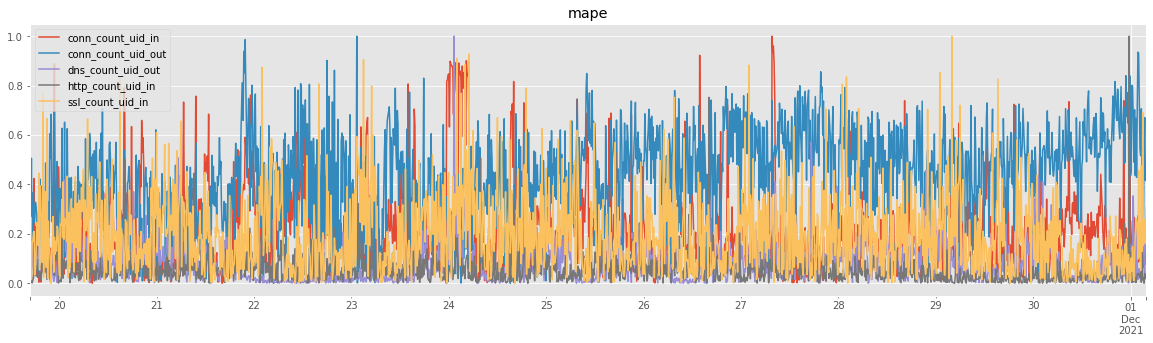

,conn_count_uid_in,conn_count_uid_out,dns_count_uid_out,http_count_uid_in,ssl_count_uid_in
count,1.651000e+03,1.651000e+03,1.651000e+03,1.651000e+03,1651.000000
mean,7.677627e+07,1.232448e+06,4.453466e+05,6.144339e+05,23153.193142
std,4.530333e+08,2.310698e+06,1.256517e+06,2.408756e+06,38481.856909
min,3.384194e+01,1.166569e+00,9.481986e-01,1.548853e-01,0.000033
25%,1.098713e+06,2.362815e+05,9.942600e+04,3.174801e+04,5459.082016
50%,3.952878e+06,6.620299e+05,2.093981e+05,1.209523e+05,16510.061871
75%,1.328248e+07,1.430269e+06,4.130186e+05,3.255026e+05,29030.625618
max,8.389782e+09,5.341581e+07,3.589523e+07,5.048779e+07,655155.373213


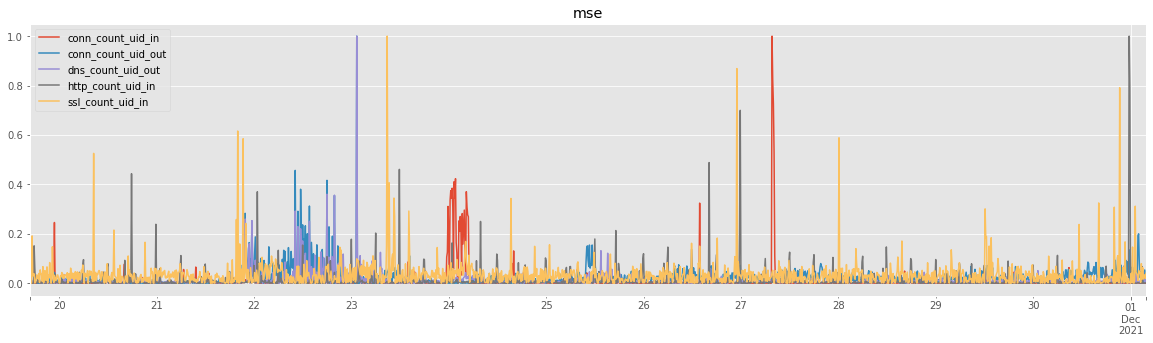

,conn_count_uid_in,conn_count_uid_out,dns_count_uid_out,http_count_uid_in,ssl_count_uid_in
count,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,3937.000608,913.643677,531.782173,503.238426,129.199054
std,7830.289263,630.828367,403.302441,601.168791,80.403440
min,5.817383,1.080078,0.973755,0.393555,0.005737
25%,1048.194824,486.087891,315.318848,178.179657,73.885513
50%,1988.184570,813.652222,457.600403,347.781982,128.491486
75%,3644.513184,1195.938049,642.664337,570.528259,170.383759
max,91595.755859,7308.612305,5991.262939,7105.476074,809.416687


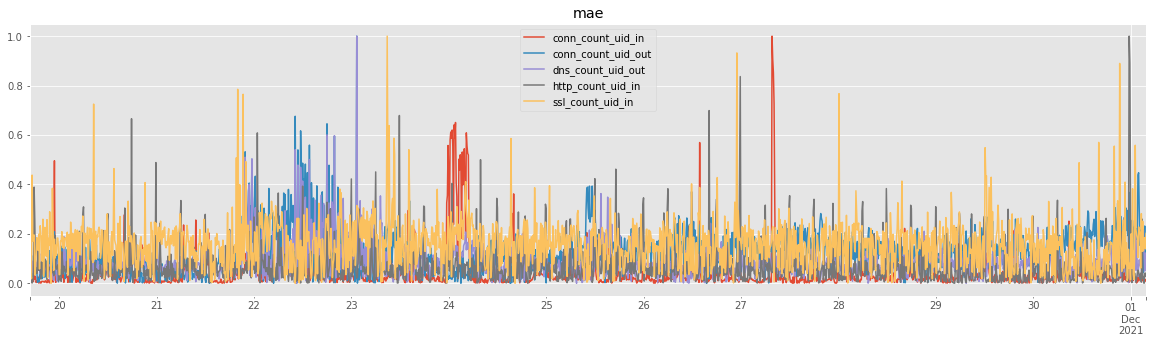

In [9]:
for name in metric_fns.keys():
    display(evals[name].describe())
    norm(evals[name], xmin=0, xmax=1).plot(figsize=(20,5))
    plt.title(name)
    plt.show()

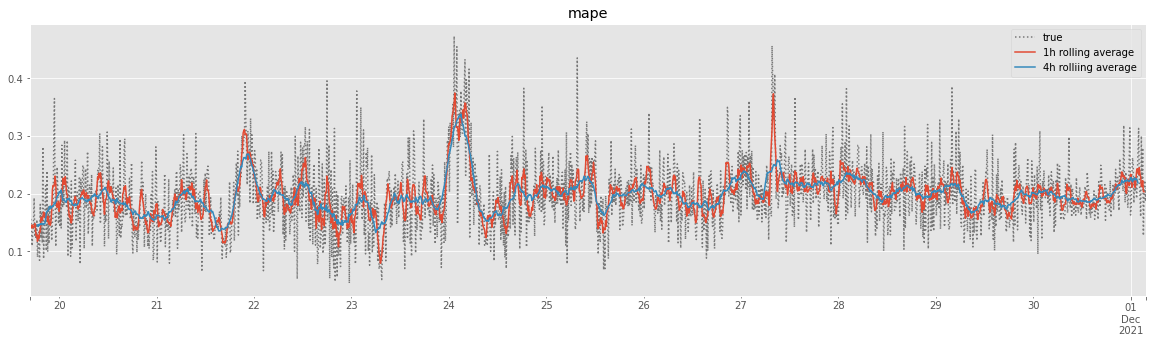

In [10]:
# df_mul = norm(evals['mape'], xmin=0, xmax=1) * norm(evals['mae'], xmin=0, xmax=1) * norm(evals['mse'], xmin=0, xmax=1)
df_mul = norm(evals['mape'], xmin=0, xmax=1)
df_mul = df_mul.mean(axis=1)
df_mul.plot(figsize=(20,5), style='C3:', label='true')
df_mul.rolling(6).mean().shift(-3).plot(figsize=(20,5), label='1h rolling average')
df_mul.rolling(24).mean().shift(-12).plot(figsize=(20,5), label='4h rolliing average')
plt.legend()
plt.title('mape')
plt.show()

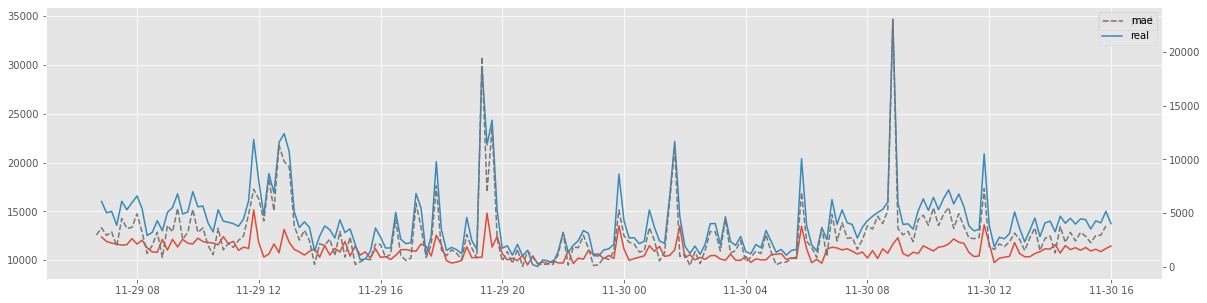

In [20]:
n = 200
metric = 'mae'
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['pred']['conn_count_uid_in'][-n:], label='pred')
ax.plot(df['real']['conn_count_uid_in'][-n:], label='real')
ax.legend()
ax2 = ax.twinx()
ax2.grid(None)
ax2.plot(evals[metric]['conn_count_uid_in'][-n:], color='C3', linestyle='--', label=metric)
# plt.errorbar(x=df['pred']['conn_count_uid_in'].index[-n-1:-1], y=df['pred']['conn_count_uid_in'][-n-1:-1], yerr=evals['mae']['conn_count_uid_in'][-n:], ecolor='0')
# plt.errorbar(df['real'].index, 'conn_count_uid_in', yerr='std', data=df['real'])
plt.legend()
plt.show()

,mae,mape,mse
conn_count_uid_in,4347.663249,0.209374,5.535833e+07
conn_count_uid_out,649.696864,0.201814,1.041188e+06
dns_count_uid_out,484.492783,1.208568,4.093648e+05
http_count_uid_in,616.854821,0.728862,1.481732e+06
ssl_count_uid_in,130.840844,0.614983,2.366215e+04


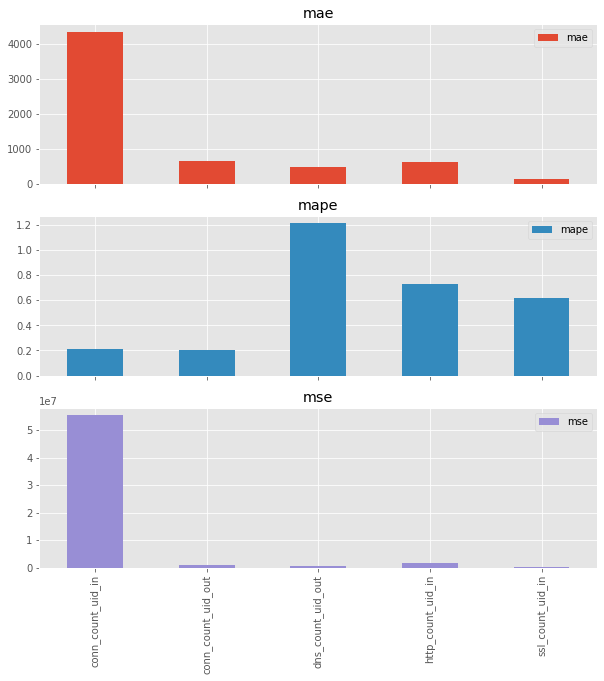

In [13]:
df = buffer_trim_null(evaluation)
# df = df[:1]

metric_fns = {
    'mape': skl.metrics.mean_absolute_percentage_error,
    'mse': skl.metrics.mean_squared_error,
    'mae': skl.metrics.mean_absolute_error,
}

results = None
for name, fn in metric_fns.items():
    result = fn(
        y_true=df['real'],
        y_pred=df['pred'],
        multioutput='raw_values'
    )
    result = pd.DataFrame(result, columns=[name], index=df['real'].columns)
    results = results.combine_first(result)\
        if results is not None\
            else result

display(results)

results.plot(kind='bar', subplots=True, figsize=(10,10))
plt.show()

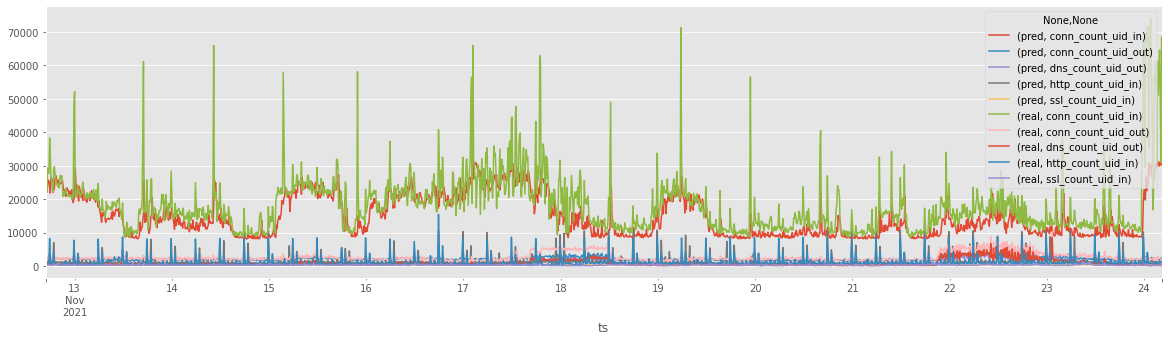

In [10]:
df = buffer_trim_null(evaluation)
df.plot(figsize=(20,5))
plt.show()

In [11]:
df = buffer_trim_null(evaluation)
(df['pred'] - df['real']).abs().describe()

,conn_count_uid_in,conn_count_uid_out,dns_count_uid_out,http_count_uid_in,ssl_count_uid_in
count,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000
mean,4347.663249,649.696864,484.492783,616.854821,130.840844
std,6039.719526,787.055874,418.015795,1049.708621,80.912157
min,4.998047,0.134521,0.808228,0.204041,0.077515
25%,1391.073975,157.071289,273.532349,146.534698,77.571678
50%,2687.521484,347.008789,406.897797,351.069611,121.069901
75%,4888.282471,767.140808,582.416687,625.700287,174.535126
max,49890.103516,7388.855225,6572.565063,8448.505188,854.414246


In [92]:
df.shape

(55, 10)

In [ ]:
# store incomming messages
buffer = pd.DataFrame([])
stripped_beg = False
for message in consumer:
    print(message)
    protocol = message.key.decode('ascii')
    df = pd.read_json(message.value, orient='index')
    df.set_index(cfg['model']['data']['in']['index'], inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    if df.empty: continue
    buffer = buffer.combine_first(df)
    if not stripped_beg and len(buffer.index) > 1 and buffer.iloc[[0]].isnull().values.any():
        buffer = buffer[1:]
        stripped_beg = True

In [24]:
# buffer.to_csv('buffer-all-1M.tsv', sep='\t')
display(buffer)

""


In [ ]:
plt.plot(buffer['conn_count_uid_in'].resample('12H').mean())
plt.plot(buffer['conn_count_uid_in'].resample('6H').mean())
plt.plot(buffer['conn_count_uid_in'].resample('3H').mean())